#Perfoming Naive Bayes on Poems from poetryfoundation.org

Data Source: https://www.kaggle.com/ultrajack/modern-renaissance-poetry

Poems from poetryfoundation.org dataset consists of poems from different genres.

Number of poems : 573

Number of Attributes/Columns in data : 5

###Attribute Information:

1. author - author name
2. content - poem content
3. poem name
4. Age - poetry style era
5. type - category/genre 

###Objective:

Given a poem, determine whether the genre that poem belong to.

##1. Reading Data

###1.1. Loading Data

The dataset is available in csv file


In [0]:
!pip install paramiko

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from nltk.stem.porter import PorterStemmer
import sklearn
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import BernoulliNB

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import io
final = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [9]:
#Before starting preprocessing lets see the number of entries left
print(final.shape)

#How many Love, Nature and Mythology poems are present in our dataset?
final['type'].value_counts()

(573, 5)


Love                    326
Nature                  188
Mythology & Folklore     59
Name: type, dtype: int64

##3. Preprocessing 

###3.1. Preprocessing Review Text

Now our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to Love, Nature and Mythology poems

In [0]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['content'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

In [0]:
nltk.download("stopwords")

In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'above', 'which', 'both', 'there', 'yourself', 'having', 'hadn', 'them', 'ma', 'below', 'were', 'than', 'between', 'y', 'wasn', "aren't", 'shan', 'won', 'most', 'was', 'same', 'once', 'more', "needn't", 'her', 'when', 'does', 'shouldn', 'they', 'had', 'it', 'are', 'didn', "isn't", 'few', 'wouldn', "doesn't", 'is', 'with', 'what', "wouldn't", 'have', 'for', 've', 'nor', 'itself', 'do', 'own', 'the', 'to', 'under', 'haven', 'hers', 'some', 'into', 'aren', "couldn't", 'has', 'on', 'these', 'those', 'up', 'too', 'should', 'o', 'mustn', 'other', 'such', 'mightn', 'couldn', 'all', 'isn', 'needn', "that'll", 'until', 'further', 'me', 'you', 'now', 'd', "mustn't", 'who', 'but', 'him', "you've", 'any', 's', 'been', 'herself', 'by', 'where', 'himself', 'i', 'why', 'he', 'from', 'yourselves', 'over', 'its', "it's", 'so', "you'll", "she's", 'she', 'did', 'ours', 'through', "won't", "don't", 'just', 'during', 'here', 'theirs', 're', 'that', 'as', 'down', 'm', "wasn't", 'doing', 't', 'only', 'again

In [13]:
# Combining all the above stundents 
from tqdm import tqdm

i=0
str1=' '
final_string=[]
all_love_words=[] # store words from love poems here
all_nature_words=[] # store words from nature poems here.
all_mythology_words=[] # store words from mythology poems here.
s=''
for sent in tqdm(final['content'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['type'].values)[i] == 'Love': 
                        all_love_words.append(s) #list of all words used to describe love poems
                    if(final['type'].values)[i] == 'Nature':
                        all_nature_words.append(s) #list of all words used to describe nature poems
                    if(final['type'].values)[i] == 'Mythology & Folklore':
                        all_mythology_words.append(s) #list of all words used to describe mythology poems    
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 573/573 [00:01<00:00, 307.26it/s]


In [0]:
#after data suplication and preprocessing we are adding the CleanedText as a new attribute of our dataset
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
final.shape

(573, 6)

In [0]:
genre = final['type'].values
text = final['CleanedText'].values

In [0]:
#splitting the dataset into train, test and cross validate 
x_train, x_test, y_train, y_test = train_test_split(text, genre, test_size=0.3)

In [18]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(401,) (401,)
(172,) (172,)


In [19]:
print("Number of love, nature and mythology datapoints in our train dataset")
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

Number of love, nature and mythology datapoints in our train dataset


{'Love': 228, 'Mythology & Folklore': 39, 'Nature': 134}

In [20]:
print("Number of love, nature and mythology datapoints in our test dataset")
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

Number of love, nature and mythology datapoints in our test dataset


{'Love': 98, 'Mythology & Folklore': 20, 'Nature': 54}

##4. Applying Bernoulli Naive Bayes

###4.1. on Bag of Words

In [21]:
#coveting text to vectors using BOW 
#will be coverting train, test and cross validate datasets seperately to overcome data leakage problem

count_vect = CountVectorizer() #in scikit-learn

#converting train data to vectors using BOW
bow_x_train = count_vect.fit_transform(x_train) 
bow_x_train.shape

(401, 6073)

In [22]:
#converting test data to vectors using BOW
bow_x_test = count_vect.transform(x_test)
bow_x_test.shape

(172, 6073)

100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


0.009


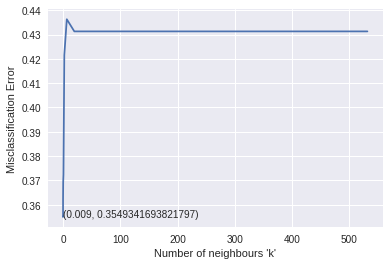

In [23]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = BernoulliNB(alpha=k)
    scores = cross_val_score(bnb, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()
    

In [24]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (0.009)

#initiate model
bnb = BernoulliNB(alpha = optimal_alpha)

#fit model
bnb.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(bow_x_test)

#calculating accuracy of model
train_acc = bnb.score(bow_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)

Training Accuracy:  0.8802992518703242
Train Error:  0.1197007481296758
Test Accuracy:  0.627906976744186
Test Error:  0.37209302325581395


In [26]:
#feature selection

# Now we can find log probabilities of different features for all the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'love' class, row_1 is for 'mythology' class, row_2 is for 'nature' class
love_features = class_features[0]
mythology_features = class_features[1]
nature_features = class_features[2]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'love_features', 'mythology_features' and 'nature_features' in descending order using argsort() function
sorted_love_features = np.argsort(love_features)[::-1]
sorted_mythology_features = np.argsort(mythology_features)[::-1]
sorted_nature_features = np.argsort(nature_features)[::-1]

print("Top 20 Important Features and their log probabilities For love Class :\n\n")
for i in list(sorted_love_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],love_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For mythology Class :\n\n")
for i in list(sorted_mythology_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],mythology_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For nature Class :\n\n")
for i in list(sorted_nature_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],nature_features[i]))    

Top 20 Important Features and their log probabilities For love Class :


love	 -->	-0.502106  
eye	 -->	-1.152633  
make	 -->	-1.270401  
thi	 -->	-1.270401  
thou	 -->	-1.334930  
shall	 -->	-1.334930  
may	 -->	-1.368826  
doth	 -->	-1.386215  
hath	 -->	-1.403912  
yet	 -->	-1.403912  
heart	 -->	-1.403912  
like	 -->	-1.403912  
sweet	 -->	-1.403912  
beauti	 -->	-1.458963  
sinc	 -->	-1.478008  
one	 -->	-1.497422  
let	 -->	-1.497422  
time	 -->	-1.517222  
still	 -->	-1.558036  
fair	 -->	-1.579086  


Top 20 Important Features and their log probabilities For mythology Class :


one	 -->	-1.098382  
great	 -->	-1.098382  
make	 -->	-1.178367  
like	 -->	-1.178367  
love	 -->	-1.178367  
made	 -->	-1.265310  
might	 -->	-1.360538  
beauti	 -->	-1.360538  
upon	 -->	-1.360538  
shall	 -->	-1.360538  
day	 -->	-1.360538  
may	 -->	-1.360538  
long	 -->	-1.465799  
eye	 -->	-1.465799  
yet	 -->	-1.465799  
old	 -->	-1.465799  
let	 -->	-1.465799  
new	 -->	-1.465799  
face	 -->	-1.4

In [30]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(bow_x_test)))

Train confusion matrix
[[204   2  22]
 [  5  23  11]
 [  6   2 126]]
Test confusion matrix
[[80  2 16]
 [ 8  2 10]
 [24  4 26]]


####Observation : 
1. Hyperparameter (alpha) = 0.009
2. Train Accuracy = 0.8802992518703242
3. Test Accuracy = 0.627906976744186

###4.2. on TF-IDF

In [31]:
#coveting text to vectors using tf-idf 

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

#converting train data to vectors using tf-idf
tf_idf_x_train = tf_idf_vect.fit_transform(x_train)
tf_idf_x_train.shape

(401, 32234)

In [32]:
#converting test data to vectors using tf-idf
tf_idf_x_test = tf_idf_vect.transform(x_test)
tf_idf_x_test.shape

(172, 32234)

100%|██████████| 13/13 [00:02<00:00,  8.04it/s]


19.683


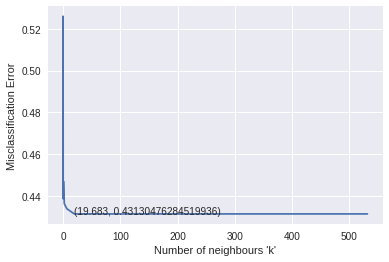

In [33]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = BernoulliNB(alpha=k)
    scores = cross_val_score(bnb, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [35]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (19.683)

#initiate model
bnb = BernoulliNB(alpha = optimal_alpha)

#fit model
bnb.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = bnb.score(tf_idf_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)

Training Accuracy:  0.5685785536159601
Train Error:  0.4314214463840399
Test Accuracy:  0.5697674418604651
Test Error:  0.43023255813953487


In [36]:
#feature selection

# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'love' class, row_1 is for 'mythology' class & row_2 is for 'nature' class
love_features = class_features[0]
mythology_features = class_features[1]
nature_features = class_features[2]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'love_features', 'mythology_features' & 'love_features' in descending order using argsort() function
sorted_love_features = np.argsort(love_features)[::-1]
sorted_mythology_features = np.argsort(mythology_features)[::-1]
sorted_nature_features = np.argsort(nature_features)[::-1]

print("Top 20 Important Features and their log probabilities For love Class :\n\n")
for i in list(sorted_love_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],love_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For mythology Class :\n\n")
for i in list(sorted_mythology_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],mythology_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For nature Class :\n\n")
for i in list(sorted_nature_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],nature_features[i]))    

Top 20 Important Features and their log probabilities For love Class :


love	 -->	-0.528032  
eye	 -->	-1.070282  
make	 -->	-1.161583  
thi	 -->	-1.161583  
thou	 -->	-1.210562  
shall	 -->	-1.210562  
may	 -->	-1.235982  
doth	 -->	-1.248938  
like	 -->	-1.262065  
hath	 -->	-1.262065  
heart	 -->	-1.262065  
yet	 -->	-1.262065  
sweet	 -->	-1.262065  
beauti	 -->	-1.302511  
sinc	 -->	-1.316365  
one	 -->	-1.330413  
let	 -->	-1.330413  
time	 -->	-1.344662  
still	 -->	-1.373783  
fair	 -->	-1.388668  


Top 20 Important Features and their log probabilities For mythology Class :


one	 -->	-0.874535  
great	 -->	-0.874535  
love	 -->	-0.905610  
like	 -->	-0.905610  
make	 -->	-0.905610  
made	 -->	-0.937681  
day	 -->	-0.970816  
upon	 -->	-0.970816  
shall	 -->	-0.970816  
beauti	 -->	-0.970816  
may	 -->	-0.970816  
might	 -->	-0.970816  
old	 -->	-1.005086  
publish	 -->	-1.005086  
let	 -->	-1.005086  
permiss	 -->	-1.005086  
long	 -->	-1.005086  
new	 -->	-1.005086  
till	 

In [37]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(tf_idf_x_test)))

Train confusion matrix
[[228   0   0]
 [ 39   0   0]
 [134   0   0]]
Test confusion matrix
[[98  0  0]
 [20  0  0]
 [54  0  0]]


####Observation : 
1. Hyperparameter (alpha) = 19.683
2. Train Accuracy =  0.5685785536159601
3. Test Accuracy = 0.5697674418604651

##5. Applying Multinomial Naive Bayes

###5.1. on Bag of Words

100%|██████████| 13/13 [00:01<00:00,  3.90it/s]


2.187


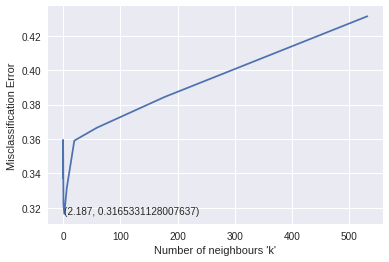

In [38]:
from sklearn.naive_bayes import MultinomialNB

#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = MultinomialNB(alpha=k)
    scores = cross_val_score(bnb, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()
    

In [40]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (2.187)

#initiate model
bnb = MultinomialNB(alpha = optimal_alpha)

#fit model
bnb.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(bow_x_test)

#calculating accuracy of model
train_acc = bnb.score(bow_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)

Training Accuracy:  0.8428927680798005
Train Error:  0.15710723192019949
Test Accuracy:  0.6395348837209303
Test Error:  0.36046511627906974


In [41]:
#feature selection

# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'love' class, row_1 is for 'mythology' class & row_2 is for 'nature' class
love_features = class_features[0]
mythology_features = class_features[1]
nature_features = class_features[2]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'love_features', 'mythology_features' & 'love_features' in descending order using argsort() function
sorted_love_features = np.argsort(love_features)[::-1]
sorted_mythology_features = np.argsort(mythology_features)[::-1]
sorted_nature_features = np.argsort(nature_features)[::-1]

print("Top 20 Important Features and their log probabilities For love Class :\n\n")
for i in list(sorted_love_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],love_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For mythology Class :\n\n")
for i in list(sorted_mythology_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],mythology_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For nature Class :\n\n")
for i in list(sorted_nature_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],nature_features[i]))    

Top 20 Important Features and their log probabilities For love Class :


broad blade	 -->	-4.394692  
cruelti	 -->	-4.959843  
cuckoo palm	 -->	-5.046357  
bedeck fyne	 -->	-5.510793  
briggflatt part	 -->	-5.576831  
crown honour	 -->	-5.611560  
compar pure	 -->	-5.620434  
care world	 -->	-5.629388  
baser thing	 -->	-5.629388  
demur suit	 -->	-5.753728  
alack one	 -->	-5.753728  
brest	 -->	-5.774307  
bee sting	 -->	-5.774307  
blood puls	 -->	-5.805993  
brought march	 -->	-5.827689  
build clothd	 -->	-5.827689  
cupid seen	 -->	-6.007411  
blond	 -->	-6.007411  
countnanc	 -->	-6.020623  
cressi	 -->	-6.061342  


Top 20 Important Features and their log probabilities For mythology Class :


broad blade	 -->	-5.883670  
cuckoo palm	 -->	-6.120381  
care world	 -->	-6.170159  
briggflatt part	 -->	-6.222544  
cruelti	 -->	-6.277827  
blackbird three	 -->	-6.499643  
aye	 -->	-6.535765  
brought march	 -->	-6.573241  
day bridal	 -->	-6.652688  
build clothd	 -->	-6.694912  
cup

In [42]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(bow_x_test)))

Train confusion matrix
[[215   1  12]
 [ 15  18   6]
 [ 28   1 105]]
Test confusion matrix
[[88  2  8]
 [13  1  6]
 [30  3 21]]


####Observation : 
1. Hyperparameter (alpha) = 2.187
2. Train Accuracy = 0.8428927680798005
3. Test Accuracy = 0.6395348837209303

###5.2. on TF-IDF

100%|██████████| 13/13 [00:00<00:00, 13.25it/s]


0.081


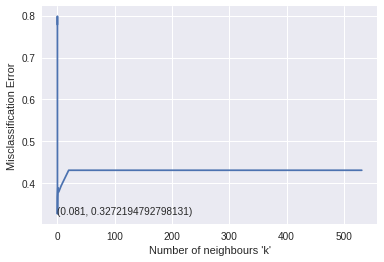

In [43]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = MultinomialNB(alpha=k)
    scores = cross_val_score(bnb, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [44]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (0.081)

#initiate model
bnb = MultinomialNB(alpha = optimal_alpha)

#fit model
bnb.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = bnb.score(tf_idf_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)

Training Accuracy:  0.9002493765586035
Train Error:  0.09975062344139651
Test Accuracy:  0.5930232558139535
Test Error:  0.40697674418604646


In [45]:
#feature selection

# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'love' class, row_1 is for 'mythology' class & row_2 is for 'nature' class
love_features = class_features[0]
mythology_features = class_features[1]
nature_features = class_features[2]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'love_features', 'mythology_features' & 'love_features' in descending order using argsort() function
sorted_love_features = np.argsort(love_features)[::-1]
sorted_mythology_features = np.argsort(mythology_features)[::-1]
sorted_nature_features = np.argsort(nature_features)[::-1]

print("Top 20 Important Features and their log probabilities For love Class :\n\n")
for i in list(sorted_love_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],love_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For mythology Class :\n\n")
for i in list(sorted_mythology_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],mythology_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For nature Class :\n\n")
for i in list(sorted_nature_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],nature_features[i]))    

Top 20 Important Features and their log probabilities For love Class :


love	 -->	-6.280124  
thi	 -->	-6.520526  
thou	 -->	-6.597250  
thee	 -->	-7.091325  
eye	 -->	-7.184852  
doth	 -->	-7.188931  
one	 -->	-7.206869  
shall	 -->	-7.241412  
let	 -->	-7.277944  
heart	 -->	-7.320161  
beauti	 -->	-7.337618  
like	 -->	-7.342915  
yet	 -->	-7.350341  
may	 -->	-7.409341  
fair	 -->	-7.414659  
make	 -->	-7.418263  
time	 -->	-7.500112  
sweet	 -->	-7.517855  
sinc	 -->	-7.526067  
hath	 -->	-7.544465  


Top 20 Important Features and their log probabilities For mythology Class :


ezra pound	 -->	-7.202997  
ezra	 -->	-7.202997  
pound	 -->	-7.213779  
canto	 -->	-7.590927  
publish	 -->	-7.966770  
one	 -->	-8.079548  
permiss	 -->	-8.180994  
canto ezra	 -->	-8.233241  
pound copyright	 -->	-8.233241  
pound reprint	 -->	-8.233241  
pound canto	 -->	-8.233241  
copyright ezra	 -->	-8.233241  
thou	 -->	-8.282195  
new	 -->	-8.293173  
copyright	 -->	-8.304048  
new direct	 -->	-8

In [46]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(tf_idf_x_test)))

Train confusion matrix
[[211   3  14]
 [  4  29   6]
 [ 11   2 121]]
Test confusion matrix
[[87  3  8]
 [14  1  5]
 [36  4 14]]


####Observation : 
1. Hyperparameter (alpha) = 0.081
2. Train Accuracy = 0.9002493765586035
3. Test Accuracy =  0.5930232558139535

##6. Conclusion


In [0]:
!sudo pip3 install PTable

In [48]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter (alpha)", "Train Accuracy", "Test Accuracy"]

x.add_row(["BOW (bernoulliNB)", 0.009, 0.8802992518703242, 0.627906976744186])
x.add_row(["TF-IDF (bernoulliNB)", 19.683, 0.5685785536159601, 0.5697674418604651])
x.add_row(["BOW (MultinomialNB)", 2.187, 0.8428927680798005, 0.6395348837209303])
x.add_row(["TF-IDF (MultinomialNB)", 0.081, 0.9002493765586035,  0.5930232558139535])

print(x)

+------------------------+------------------------+--------------------+--------------------+
|         Model          | Hyperparameter (alpha) |   Train Accuracy   |   Test Accuracy    |
+------------------------+------------------------+--------------------+--------------------+
|   BOW (bernoulliNB)    |         0.009          | 0.8802992518703242 | 0.627906976744186  |
|  TF-IDF (bernoulliNB)  |         19.683         | 0.5685785536159601 | 0.5697674418604651 |
|  BOW (MultinomialNB)   |         2.187          | 0.8428927680798005 | 0.6395348837209303 |
| TF-IDF (MultinomialNB) |         0.081          | 0.9002493765586035 | 0.5930232558139535 |
+------------------------+------------------------+--------------------+--------------------+


After the analysis of 573 data points we conclude that the best model is when we apply **Multinomial Naive Bayes on BOW** with

**Hyperparameter (K) = 2.187**

**Training Accuracy = 84.28927680798005%**

**Test Accuracy = 63.95348837209303%**